#### Intro to Quantum Programming - Spring 2021
## Homework 5: Due 04/12/2021

For each exercise below, add as many cells as you want. To evaluate your submission, I will do **Restart and Run All**. . For help with Markdown, see [this link](https://www.markdownguide.org/).

In [1]:
# Here's a cell for import statements... add more if necessary (or just import below as needed)
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT, PhaseEstimation
from qiskit.circuit.library.standard_gates import XGate, CXGate, SGate, CPhaseGate, PhaseGate, RYGate
import numpy as np
import math
from fractions import Fraction

----
#### Exercise 5.1

Write a function named `U4mod55` that returns a circuit that implements the following modular multiplication:

$$ U|y\rangle = |4y \bmod 55\rangle$$

Your circuit must work for any initial state $|y\rangle$ from 0 to 54. Note that 4 is not prime, but 4 and 55 are relatively prime. You will need to deal with the $\bmod 55$ step. The example in the textbook is a good starting point. If you use any ancilla qubits, you must return them to zero without using reset.

In [2]:
# Internal Function used to convert a number into a circuit that subtracts by that much
# Works recursively
# Called by the Sub function below

# Doesn't use the ancillary bit

# Variables: bit is the number (in binary), q1 is the quantum circuit, numQubits is the number of qubits in q1
def GenSub(bit, q1, numQubits):
    height = len(bit)
    if bit[0] == '1':
        q1.x(height - 1)
        location = numQubits - height
        for i in reversed(range(location)):
            gates = []
            for x in reversed(range(numQubits - 1 - location, numQubits - i)):
                gates.insert(0, x)
            q1.append(XGate().control(len(gates) - 1), gates)
        q1.barrier()
    if height != 1:
        GenSub(bit[1:], q1, numQubits)

In [3]:
# Function that subtracts the circuit by a certain amount
# Calls on GenSub

# Requires the one ancillary bit

# Variables: val is the number to subtract by, numQubits is the number of qubits in the circuit
def Sub(val, numQubits):
    a = QuantumRegister(numQubits, 'a')
    bit = '{0:08b}'.format(val)
    q1 = QuantumCircuit(a)            
    
    GenSub(bit,q1, numQubits - 1)
    return q1

In [4]:
# Internal Function used to convert a number into a circuit that adds by that much (with a control bit for the sign)
# Works recursively
# Called by the Add function below

# Doesn't use the ancillary bit

# Variables: bit is the number (in binary), q1 is the quantum circuit
def GenAddition(bit, q1, numQubits):
    height = len(bit)
    if height != 1:
        GenAddition(bit[1:], q1, numQubits)
    if bit[0] == '1':
        location = numQubits - height
        for i in range(location):
            gates = []
            for x in reversed(range(numQubits - 1 - location, numQubits - i)):
                gates.insert(0, x)
            gates.insert(0,numQubits)
            q1.append(XGate().control(len(gates) - 1), gates)
        q1.cx(numQubits, height - 1)
        q1.barrier()

In [5]:
# Function that adds the circuit by a certain amount (using the sign qubit as a control)
# Calls on GenSub

# Requires the one ancillary bit

# Variables: val is the number to add by, numQubits is the number of qubits in the circuit
def Add(val, numQubits):
    a = QuantumRegister(numQubits, 'a')
    bit = '{0:08b}'.format(val)
    q1 = QuantumCircuit(a)            
    
    GenAddition(bit,q1,numQubits-1)
    return q1

In [6]:
# Multiplies the qubits by 2 by shifting all of the qubits down

def Shift():
    a = QuantumRegister(9, 'a')
    q1 = QuantumCircuit(a)
    q1.swap(0,7)
    q1.swap(1,7)
    q1.swap(2,7)
    q1.swap(3,7)
    q1.swap(4,7)
    q1.swap(5,7)
    q1.swap(6,7)
    q1.barrier()
    return q1

In [7]:
# Performs (2*y)modx, where y is the value currently in the circuit

# Variables: a is the quantum register, x is the value to mod by (55 in the examples)
def modTwo(x, numQubits):
    a = QuantumRegister(numQubits, 'a')
    q1 = QuantumCircuit(a)    
    
#     Multiplies the circuit by two
    q1.append(Shift(),a)
#     Subtracts by x
    q1.append(Sub(x, numQubits), a)
    
#     Gets the sign (if circuit - x > 0)
    q1.cx(numQubits-2,numQubits-1)
    q1.barrier()
    
#     If circuit - x > 0, adds by x
    q1.append(Add(x,numQubits), a)
    
#     Returns the ancillary bit to |0>
    q1.x(0)
    q1.cx(0,numQubits-1)
    q1.x(0)
    
    q1.barrier()
    return q1
    

In [8]:
# performs (4*y) mod 55 to a circuit
# Does this by doing 2*(2*y mod 55) mod 55
def U4mod55():
    a = QuantumRegister(9, 'a')
    q1 = QuantumCircuit(a)
    q1.append(modTwo(55, 9),a)
    q1.append(modTwo(55, 9),a)
    return q1

Draw your circuit below.

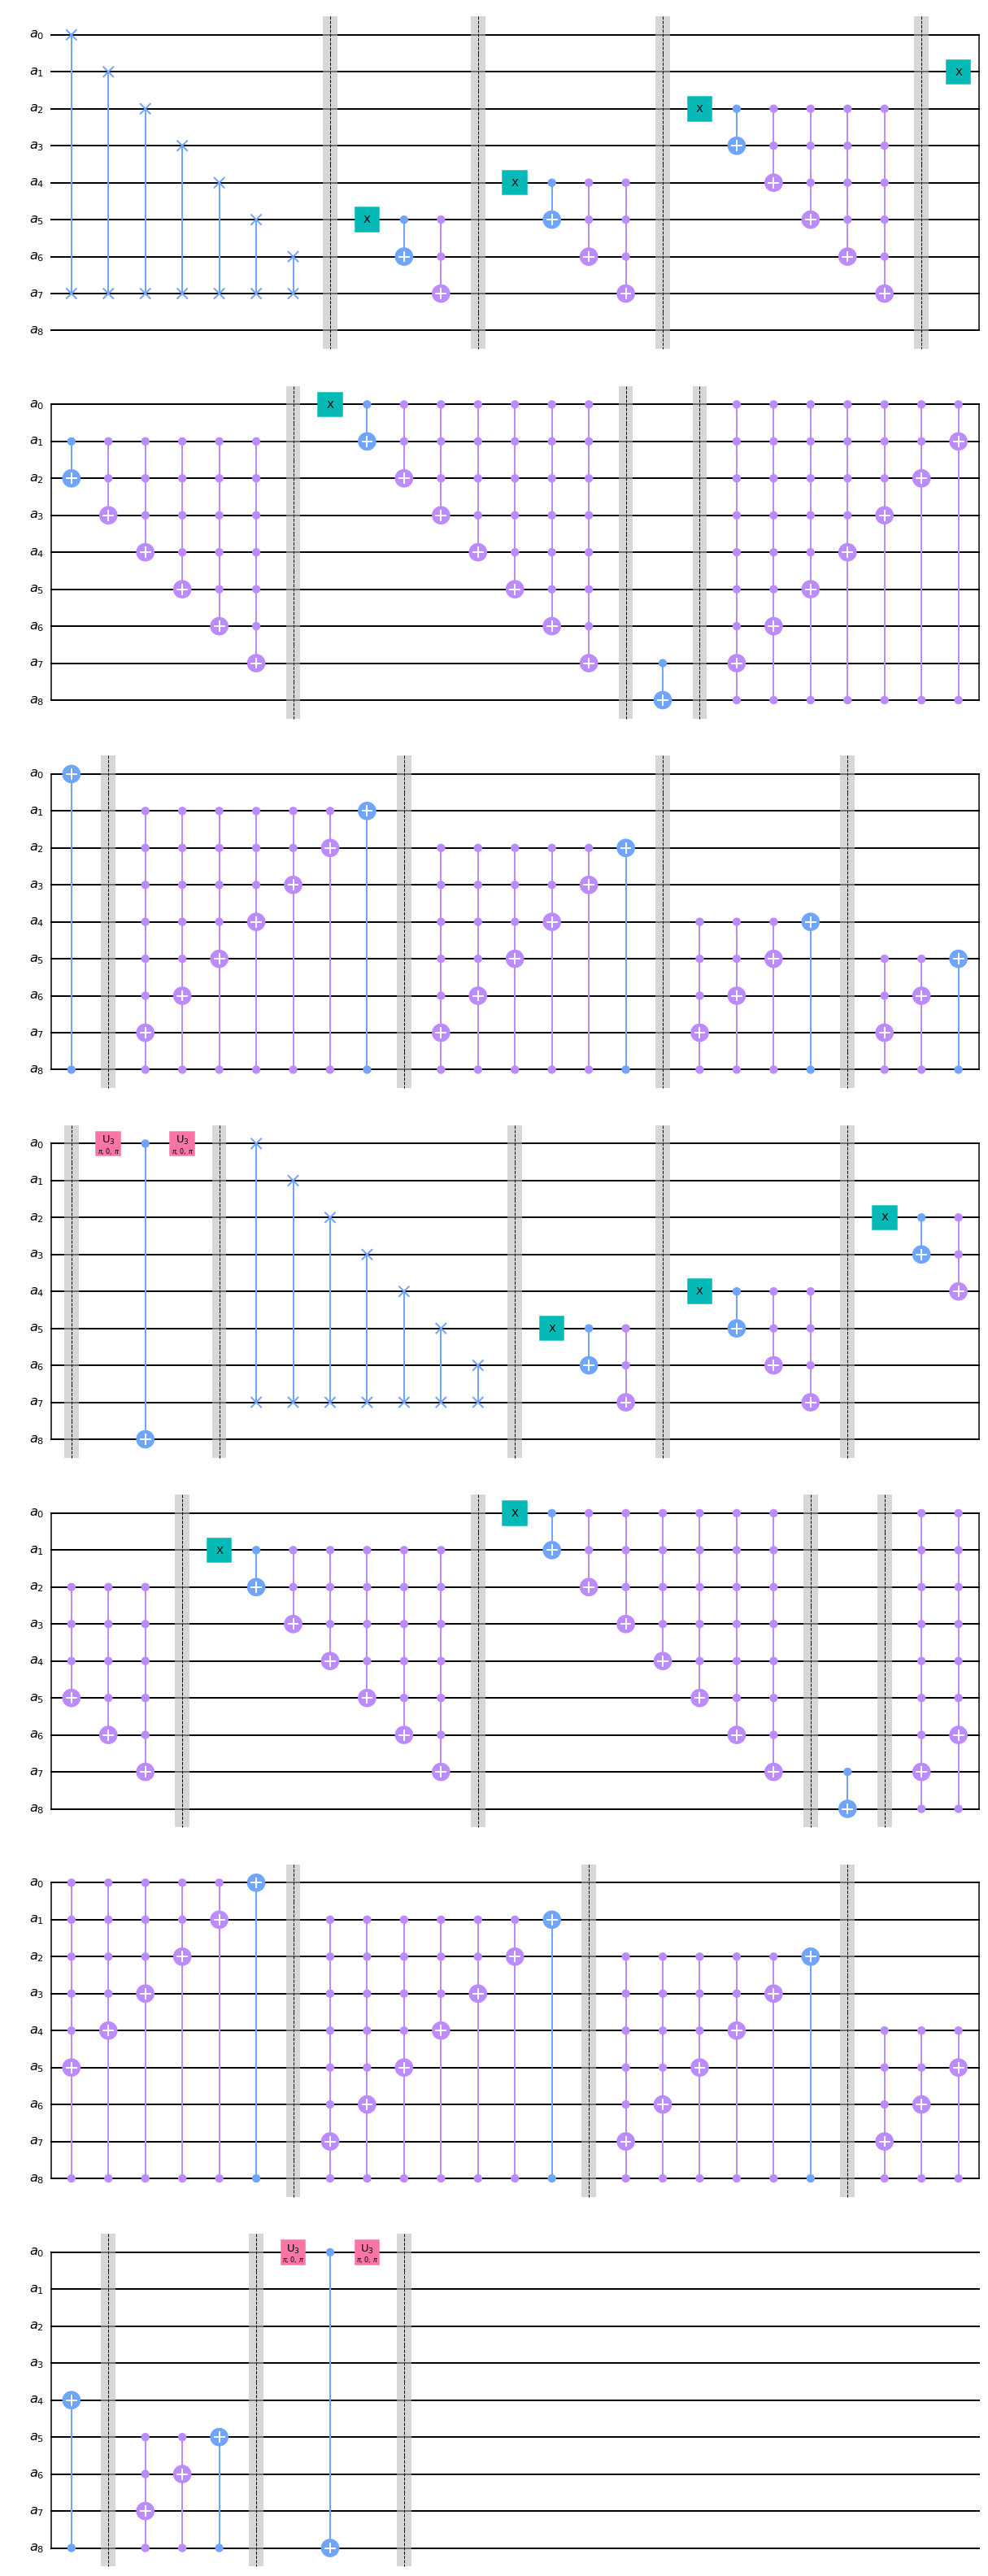

In [9]:
U4mod55().decompose().decompose().draw('mpl')

Run the following code to print the values of $4y \bmod 55$ for y from 12 to 30.

In [10]:
def modValues(a, M):
    for y in range(12,31):
        print((a * y) % M, end='  ')
    return

modValues(4,55)

48  52  1  5  9  13  17  21  25  29  33  37  41  45  49  53  2  6  10  

Run the following cell to demonstrate your quantum circuit for values of $U|x\rangle$ for x = 12 to 16, in order to show that you are calculating the correct values. Before running the cell, set the number of qubits required for your circuit.

In [11]:
num_qubits = 9   # set to the number of qubits used in your U4mod55() circuit

def init5(n, circ):   # uses lower 5 bits to set value between 0 and 54
    for m in range(0,6):
        if (n & (1<<m)): circ.x(m)
    return

print("Expected Answers (using classical comp): \t", end='')
modValues(4, 55)
print("\n")

print("Actual Answers (using quantum): \t\t", end='')

qsim = Aer.get_backend('qasm_simulator')
for x in range(12,31):
    cc = QuantumCircuit(num_qubits)
    init5(x, cc)
    cc.append(U4mod55(), list(range(0,num_qubits)))
    cc.measure_all()
    job = execute(cc, qsim, shots=1)  # default number of shots is 1024, but you can specify
    out = job.result().get_counts()
    for val in out:
        print(int(val,2), end = '  ')


Expected Answers (using classical comp): 	48  52  1  5  9  13  17  21  25  29  33  37  41  45  49  53  2  6  10  

Actual Answers (using quantum): 		48  52  1  5  9  13  17  21  25  29  33  37  41  45  49  53  2  6  10  

#### Exercise 5.2 

Using the function from 5.1, write Python code to find $r$, the period of $U^y$, using the brute force method.  Compute $U^y|1\rangle$ for $y$ until you get an answer of 1. ($U^y|1\rangle$ is $y$ copies of $U$ with an input of $|1\rangle$.)

In [12]:
# Answer is where I track the current value of the period, it is the iterator to track y
answer = 0
it = 0

print("Ouputs for each iteration are: ")

# Repeates this loop until the answer is 1
# Much of this loop is taken from the question above
# Also, prints out all of the answers for each iteration until an answer is 1
while answer != 1:
    it += 1
    qsim = Aer.get_backend('qasm_simulator')
    
    cc = QuantumCircuit(num_qubits)
    init5(1, cc)
    for i in range(it):
        cc.append(U4mod55(), list(range(0,num_qubits)))
    cc.measure_all()
    job = execute(cc, qsim, shots=1)  # default number of shots is 1024, but you can specify
    out = job.result().get_counts()
    answer = int(val,2)
#     print(answer)
#     print(it)
    for val in out:
        print(int(val,2), end = '  ')
        answer = int(val,2)


print("\n\nTo get an answer of 1, y = " + str(it), end = '\n')
print("\nFinal answer: \n\t\ty = " + str(it) + "\n\t\t𝑈^" + str(it) + "|1⟩ = 1")

Ouputs for each iteration are: 
4  16  9  36  34  26  49  31  14  1  

To get an answer of 1, y = 10

Final answer: 
		y = 10
		𝑈^10|1⟩ = 1


#### Exercise 5.3
Using the [code from the textbook](http://oreilly-qc.github.io?p=9-3) as an example, implement a function that takes a vector (a list of values) and returns a circuit that creates an amplitude-encoded version of the vector. There is no Qiskit code with the example, so this is essentially a matter of porting the code from QCEngine to Qiskit.

Demonstrate your function with the three vectors from Table 9-1.  Also demonstrate your code with one eight-element vector, to show that it works with any vector with $2^n$ elements. The input vector does not need to be normalized.  I will also test your code with one or more vectors of my choosing.

Do not use the Qiskit Initialize instruction to do this. Follow the code in the textbook. It would be nice if you understand the code, but it's not strictly necessary, as long as it works.  Though it's not exactly the same, the discussion in section 2.9 of the Dervoric paper (posted on Moodle) may give you some insight.

In [13]:
# Internal function used to facilitate the code that converts a number to the list format preferred by Qiskit
# Variables: num to be converted, ret list to be used
def convertToList(num, ret):
    bit = "{0:b}".format(num)
    for i in reversed(range(len(bit))):
        if bit[i] == '1':
            ret.append(len(bit) - i - 1)

In [14]:
# Function that takes a vector vec and a quantum circuit qreg, and creates an amplitude-encoded version of the vector
# Variables: vec vector, qreg quantum circuit
def amplitude_encode(vec, qreg):
    reg_mask = (1 << num_qubits) - 1 
    vec_mag_sqr = 0.0
    
    for i in range(len(vec)):
        vec_mag_sqr += vec[i] * vec[i]

    remaining_power = vec_mag_sqr;
    if vec[0] >= 0:
        first_phase = 0
    else:
        first_phase = 180


    if first_phase != 0:
        qreg.x(0)
        qreg.p(first_phase, 0)
        qreg.x(0)

    for i in range(1, len(vec)):
        power = vec[i] * vec[i];
        
        if (power > 0):
            if vec[i] >= 0:
                phase = 0
            else:
                phase = 180
            phase -= first_phase
            
            while (phase <= -180):
                phase += 360;
                
            top_bit = 1;

            while ((top_bit << 1) <= i):
                top_bit <<= 1
            
            cond_bits = reg_mask ^ top_bit;
#             power = int(power)
#             remaining_power = int(remaining_power)
            split = power / remaining_power
            
            theta = 2 * math.asin(math.sqrt(split))
            
            not_mask = reg_mask ^ top_bit
            cnot_mask = i ^ top_bit
                    
            if (phase == 180):
                theta = -theta
            
            if (cnot_mask):
                target = []
                control = []
                convertToList(cnot_mask,target)
                convertToList(top_bit,control)
                for i in target:
                    qc.cx(control[0], i)
            if (not_mask):
                nots = []
                convertToList(not_mask,nots)
                for i in nots:
                    qc.x(i)
            target = []
            convertToList(cond_bits, target)
            convertToList(top_bit, target)
            qc.append(RYGate((theta)).control(len(target)-1), target)
            
            if (phase != 0 and phase != 180):
                qreg.cz(phase)
            
            if (not_mask):
                target = []
                convertToList(not_mask, target)
                for i in target:
                    qc.x(i)
                    
            if (cnot_mask):
                target = []
                convertToList(cnot_mask, target)
                control = []
                convertToList(top_bit, control)
                for i in target:
                    qc.cx(control, i)
            remaining_power -= power

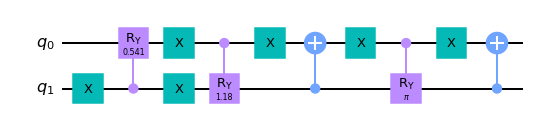

In [15]:
# Example of the circuit with vector [0, 1, 2, 3]
# Prints out the generated circuit
vector = [0, 1, 2, 3]
num_qubits = int(math.log(len(vector),2))
qc = QuantumCircuit(num_qubits)
amplitude_encode(vector, qc)
qc.draw('mpl')

In [16]:
# We can examine the state vector from the circuit to demonstrate it working 
# This will normalize the state vector to show the amplitude (more or less)

v = Statevector.from_instruction(qc)
finalAnswer = []
shortest = 1
for i in range(len(vector)):
    x = v.data[i]
    finalAnswer.append(x)
    if shortest > x and np.round(x, 2) > 0:
        shortest = v.data[i]
for i in range (len(finalAnswer)):
    finalAnswer[i] = np.round(finalAnswer[i].real / shortest.real, 2)
    
print("Expected values: \t[0,   1,   2,   3]")
print("Actual values: \t\t" +str(finalAnswer))


print("\n\nFull Statevector: \t" + str(np.round(v.data[:], 3)))


Expected values: 	[0,   1,   2,   3]
Actual values: 		[0.0, 1.0, 2.0, 3.0]


Full Statevector: 	[0.   +0.j 0.267+0.j 0.535+0.j 0.802+0.j]


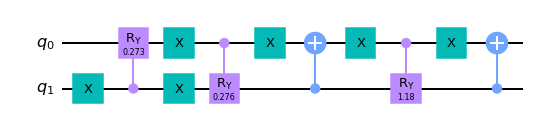

In [17]:
# Example of the circuit with vector [6, 1, 1, 4]
vector = [6, 1, 1, 4]
num_qubits = int(math.log(len(vector),2))
qc = QuantumCircuit(num_qubits)
amplitude_encode(vector, qc)

qc.draw('mpl')

In [18]:
# We can examine the state vector from the circuit to demonstrate it working 
# This will normalize the state vector to show the amplitude (more or less)

v = Statevector.from_instruction(qc)
finalAnswer = []
shortest = 1
for i in range(len(vector)):
    x = v.data[i]
    finalAnswer.append(x)
    if shortest > x and np.round(x, 2) > 0:
        shortest = v.data[i]
for i in range (len(finalAnswer)):
    finalAnswer[i] = np.round(finalAnswer[i].real / shortest.real, 2)
    
print("Expected values: \t[6,   1,   1,   4]")
print("Actual values: \t\t" +str(finalAnswer))


print("\n\nFull Statevector: \t" + str(np.round(v.data[:], 3)))

Expected values: 	[6,   1,   1,   4]
Actual values: 		[6.0, 1.0, 1.0, 4.0]


Full Statevector: 	[0.816+0.j 0.136+0.j 0.136+0.j 0.544+0.j]


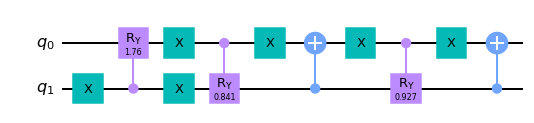

In [19]:
# Example of the circuit with vector [0.52, 0.77, 0.26, 0.26]
vector = [0.52, 0.77, 0.26, 0.26]
num_qubits = int(math.log(len(vector),2))
qc = QuantumCircuit(num_qubits)
amplitude_encode(vector, qc)

qc.draw('mpl')

In [20]:
# We can examine the state vector from the circuit to demonstrate it working 
# This will normalize the state vector to show the amplitude (more or less)

v = Statevector.from_instruction(qc)
finalAnswer = []
shortest = 1
for i in range(len(vector)):
    x = v.data[i]
    finalAnswer.append(x)
    if shortest > x and np.round(x, 2) > 0:
        shortest = v.data[i]
for i in range (len(finalAnswer)):
    finalAnswer[i] = np.round(finalAnswer[i].real / shortest.real, 2)
    
print("Expected values: \t[2,   3,   1,   1]")
print("Actual values: \t\t" +str(finalAnswer))


print("\n\nFull Statevector: \t" + str(np.round(v.data[:], 3)))

Expected values: 	[2,   3,   1,   1]
Actual values: 		[2.0, 2.96, 1.0, 1.0]


Full Statevector: 	[0.52 +0.j 0.771+0.j 0.26 +0.j 0.26 +0.j]


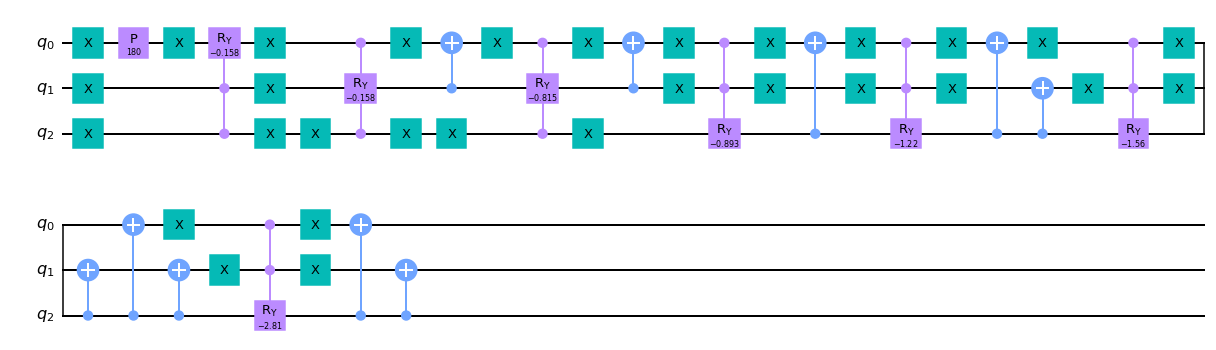

In [21]:
# Example of the circuit with vector [-1.0, 1.0, 1.0, 5.0, 5.0, 6.0, 6.0, 6.0]
vector = [-1.0, 1.0, 1.0, 5.0, 5.0, 6.0, 6.0, 6.0]
num_qubits = int(math.log(len(vector),2))
qc = QuantumCircuit(num_qubits)
amplitude_encode(vector, qc)


qc.draw('mpl')

In [22]:
# We can examine the state vector from the circuit to demonstrate it working 
# This will normalize the state vector to show the amplitude (more or less)

v = Statevector.from_instruction(qc)
finalAnswer = []
shortest = 1
for i in range(len(vector)):
    x = v.data[i]
    finalAnswer.append(x)
    if shortest > x and np.round(x, 2) > 0:
        shortest = v.data[i]
for i in range (len(finalAnswer)):
    finalAnswer[i] = np.round(finalAnswer[i].real / shortest.real, 2)
    
print("Expected values: \t[-1,   1,   1,   5,   5,   6,   6,   6]")
print("Actual values: \t\t" +str(finalAnswer))


print("\n\nFull Statevector: \t" + str(np.round(v.data[:], 3)))

Expected values: 	[-1,   1,   1,   5,   5,   6,   6,   6]
Actual values: 		[-1.0, 1.0, 1.0, 5.0, 5.0, 6.0, 6.0, 6.0]


Full Statevector: 	[-0.047-0.063j  0.047+0.063j  0.047+0.063j  0.236+0.316j  0.236+0.316j
  0.283+0.379j  0.283+0.379j  0.283+0.379j]
